In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
%matplotlib inline

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

## EM, Multiclass,  Single Confusion Matrix

In [13]:
def E_step_MC_single(rho, theta, r):
    num_data = r.shape[0]
    num_classes = theta.shape[0]
    num_experts = r.shape[1]
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k,t]) \
                                                      for j in range(num_experts)] for t in range(num_classes)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k_p,t]) \
                                                for j in range(num_experts)] for t in range(num_classes)]) \
                                              for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
    return zeds

In [14]:
def M_step_MC_single(z,r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            numerator=0
            denominator=0
            for i in range(num_data):
                for j in range(num_classes):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
  
            thet[k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh

In [15]:
# A function to run it:

def results_MC_single(data_file, true_class_file):
    data = np.load(data_file)
    trueCls = np.load(true_class_file)
    
    # Reconfigure data to resemble that used in Liu and Wang

    r = np.argmax(data,axis=2)

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step_MC_single(rho, theta, r)
        theta, rho = M_step_MC_single(z, r)
        ctr+=1

    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Shared Confusion Matrix"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print theta
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy
    

## EM, Multiclass, Multiple Confusion Matrices

In [16]:
def E_step_MC_multiple(rho, r, thetas):
    num_data = r.shape[0]
    num_classes = thetas.shape[1]
    num_experts = r.shape[1]    
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([thetas[j,k,r[i,j]] for j in range(num_experts)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([thetas[j,k_p,r[i,j]]\
                                                                       for j in range(num_experts)]) \
                                                                          for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
            
    return zeds

In [17]:
def M_step_MC_multiple(z, r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_experts,num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            for j in range(num_experts):
                numerator=0
                denominator=0
                for i in range(num_data):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
                thet[j,k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh
                    

In [18]:
# Now run it:

def results_MC_multiple(data_file, true_class_file):
    # Load Data
    data = np.load(data_file)
    trueCls = np.load(true_class_file)   
    
    # Reconfigure data to resemble that used in Liu and Wang
    if len(data.shape)==3:
        # Multinomial data
        r = np.argmax(data,axis=2)
    elif len(data.shape)==4:
        # Yes/no data
        r = np.zeros((data.shape[0], data.shape[1]))
        for n in range(data.shape[0]):
            for exp in range(data.shape[1]):
                # Use class_designation function to make a class designation for this data point.  
                r[n,exp] = class_designation(data[n,exp])

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))
    
    # All the confusion matrices start out the same
    thetas = np.stack([theta]*num_experts)

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step_MC_multiple(rho, r, thetas)
        thetas, rho = M_step_MC_multiple(z, r)
        ctr+=1
        
    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Separate Confusion Matrices"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print thetas
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy

## EM, Yes/No

In [19]:
def E_step_YN(rho, r, thetas):
    num_data = r.shape[0]
    num_classes = thetas.shape[1]
    num_experts = r.shape[1]    
    
    zeds = np.zeros((num_data, num_classes))
    
    for n in range(num_data):
        for k in range(num_classes):
            log_numerator = 0
            for j in range(num_experts):
                for k_p in range(num_classes):
                    log_numerator += np.log(rho[k]) + r[n,j,k_p,1]*np.log(thetas[j,k,k_p]) +\
                        r[n,j,k_p,0]*np.log(1.-thetas[j,k,k_p])
            
            zeds[n,k] = np.exp(log_numerator)
    zeds = zeds/zeds.sum(axis=1)[:,np.newaxis]
            
    return zeds

In [20]:
def M_step_YN(z, r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_experts,num_classes,num_classes))
    for k in range(num_classes):
        for k_p in range(num_classes):
            for j in range(num_experts):
                numerator=np.sum([z[n,k]*r[n,j,k_p,1] for n in range(num_data)])
                denominator=np.sum([z[n,k]*(r[n,j,k_p,1] + r[n,j,k_p,0]) for n in range(num_data)])
                thet[j,k,k_p] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh

In [21]:
# Now run it:

def results_YN(data_file, true_class_file):
    # Load Data
    r = np.load(data_file)
    trueCls = np.load(true_class_file)   

    # Number of data points
    num_data     = r.shape[0]
    # Number of experts performing classification
    num_experts  = r.shape[1]
    # Number of classes
    num_classes  = r.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))
    
    # All the confusion matrices start out the same
    thetas = np.stack([theta]*num_experts)

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step_YN(rho, r, thetas)
        thetas, rho = M_step_YN(z, r)
        ctr+=1
        
    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Separate Confusion Matrices: YN"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print thetas
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy

## Multiclass--Easy

In [22]:
ran = ['40','80','100','200','500']
results_MC_single_easy=np.zeros(len(ran))
results_MC_multiple_easy=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/same_preset_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/same_preset_MC_'+num+'_5_4_reference_classes.npy'
    results_MC_single_easy[ii] = results_MC_single(data, trueCls)
    results_MC_multiple_easy[ii] = results_MC_multiple(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[  9.49623743e-01   2.50809754e-02   3.27412376e-04   2.49678689e-02]
 [  2.41758643e-02   9.20785423e-01   4.48207338e-02   1.02179790e-02]
 [  9.34764688e-02   3.08552197e-02   8.16721486e-01   5.89468259e-02]
 [  8.48178499e-02   6.17750843e-02   7.00801846e-02   7.83326881e-01]]
Rho: [ 0.25009184  0.26085865  0.25641973  0.23262978]
Accuracy is 95.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.71592972  0.07722236  0.0981307   0.10871721]
  [ 0.07528594  0.73418469  0.06786897  0.12266041]
  [ 0.09885986  0.10752876  0.67221556  0.12139582]
  [ 0.10068568  0.11867694  0.11099314  0.66964424]]

 [[ 0.65145628  0.06731064  0.13746996  0.14376312]
  [ 0.06979614  0.70222429  0.13006856  0.09791101]
  [ 0.06527867  0.07030674  0.76965163  0.0

## Multiclass--hard

In [23]:
ran = ['40','80','100','200','500']
results_MC_single_extrahard=np.zeros(len(ran))
results_MC_multiple_extrahard=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/extrahard_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/extrahard_MC_'+num+'_5_4_reference_classes.npy'
    results_MC_single_extrahard[ii] = results_MC_single(data, trueCls)
    results_MC_multiple_extrahard[ii] = results_MC_multiple(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[ 0.67841758  0.06463535  0.07754329  0.17940378]
 [ 0.16663975  0.6130368   0.15656751  0.06375594]
 [ 0.0314023   0.07782152  0.68963642  0.20113975]
 [ 0.10250931  0.11875205  0.19862498  0.58011366]]
Rho: [ 0.24985445  0.25153834  0.26416265  0.23444456]
Accuracy is 90.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.38169501  0.22055959  0.18139226  0.21635315]
  [ 0.1464923   0.48327289  0.19761414  0.17262068]
  [ 0.11435532  0.18918553  0.46242333  0.23403583]
  [ 0.15957372  0.2341612   0.23077649  0.37548859]]

 [[ 0.41238617  0.15513643  0.28770163  0.14477577]
  [ 0.23576236  0.35547535  0.24155758  0.16720471]
  [ 0.20177271  0.14985028  0.47355202  0.17482499]
  [ 0.25293998  0.15803331  0.37523197  0.21379474]]

 [[ 0.28457894  0

## Yes/No--Easy

In [24]:
ran = ['40','80','100','200','500']
results_YN_easy = np.zeros(len(ran))
# results_yn_easy_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/same_preset_YN_'+num+'_5_4.npz.npy'
    trueCls = '../data/same_preset_MC_'+num+'_5_4_reference_classes.npy'
    results_YN_easy[ii] = results_YN(data, trueCls)
#     results_yn_easy_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Separate Confusion Matrices: YN
40 data points
Converged within 2 iterations
Theta:
[[[  9.99999994e-01   1.00000006e-01   1.60358358e-18   5.74760047e-22]
  [  1.00000003e-01   7.99999997e-01   1.00000000e-01   1.07948330e-16]
  [  4.53628020e-18   2.17344327e-15   1.00000000e+00   2.57901418e-20]
  [  2.88379345e-20   2.00000000e-01   1.10701342e-20   8.00000000e-01]]

 [[  9.99999994e-01   1.99999997e-01   3.47721565e-17   5.74760047e-22]
  [  2.40138644e-09   8.00000005e-01   1.00000000e-01   1.07948330e-16]
  [  1.00000000e-01   1.00000000e-01   1.00000000e+00   2.57901418e-20]
  [  1.81659131e-20   1.00000000e-01   1.11198627e-20   8.00000000e-01]]

 [[  7.99999997e-01   1.00000006e-01   6.83803151e-23   5.02933602e-15]
  [  1.00000000e-01   8.99999997e-01   5.52105930e-13   1.14007162e-13]
  [  1.00000000e-01   1.00000000e-01   8.00000000e-01   1.00000000e-01]
  [  1.00000000e-01   3.00000000e-01   1.00000000e-01   

## Yes/No--Hard

In [25]:
ran = ['40','80','100','200','500']
results_YN_extrahard=np.zeros(len(ran))
# results_yn_extrahard_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/extrahard_YN_'+num+'_5_4.npz.npy'
    trueCls = '../data/extrahard_MC_'+num+'_5_4_reference_classes.npy'
    results_YN_extrahard[ii] = results_YN(data, trueCls)
#     results_yn_extrahard_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Separate Confusion Matrices: YN
40 data points
Converged within 2 iterations
Theta:
[[[  7.27052027e-01   5.08226378e-04   1.83000100e-07   1.07255428e-08]
  [  1.06406921e-06   9.99843994e-01   1.61801987e-05   1.00555006e-06]
  [  1.10769429e-07   4.96302445e-06   9.99977454e-01   3.91991528e-07]
  [  6.47274331e-07   3.16663200e-05   1.75844399e-05   9.99876978e-01]]

 [[  2.72645121e-01   9.08182808e-02   1.00315147e-07   6.75250446e-08]
  [  2.81066007e-13   5.00299374e-01   7.80646992e-08   4.00179037e-01]
  [  2.17462517e-13   3.33326413e-01   6.66657126e-01   2.22222951e-01]
  [  9.99878419e-02   1.04254165e-06   2.99981014e-01   7.99901794e-01]]

 [[  7.26986757e-01   9.09632832e-02   9.08809912e-02   9.08813324e-02]
  [  2.00159309e-01   6.00161457e-01   3.00147513e-01   1.00033341e-01]
  [  9.80527186e-07   2.22210314e-01   6.66659044e-01   2.22218021e-01]
  [  1.99977062e-01   2.00001926e-01   1.13985911e-06   

## Simulated Annealing Results

In [28]:
SimAn_YN_easy = [100, 100, 100, 100, 99]
SimAn_YN_hard = [97, 92, 99, 96, 96]
SimAn_MC_easy = [97, 97, 100, 100, 100]
SimAn_MC_hard = [87, 85, 95, 88, 93]
PyMC_MC = [100, 100 ,88, 98.5]
PyMC_YN = [100, 100 ,97, 100]

## Generate Plots

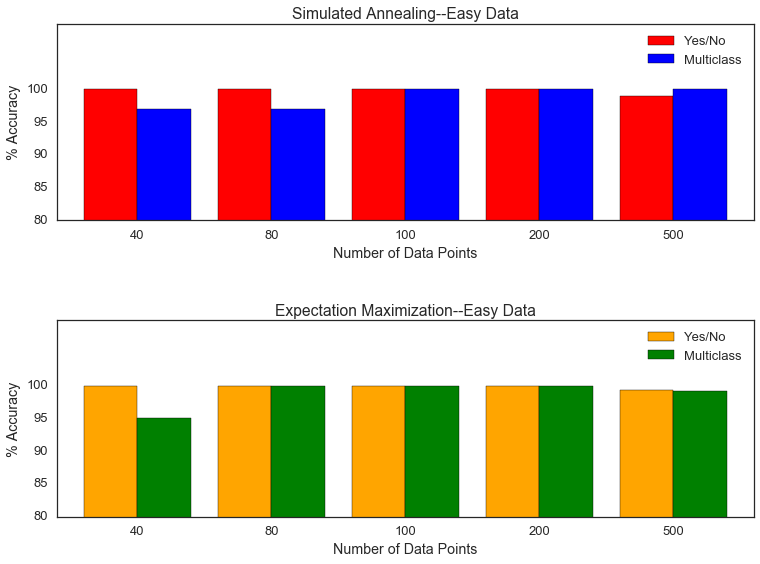

In [31]:
plt.subplot(2,1,1)
plt.tight_layout(0.5,5,0.5)
plt.bar(range(5),SimAn_YN_easy,0.4, color='red', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, SimAn_MC_easy, 0.4, color="blue", label="Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Simulated Annealing--Easy Data")

plt.subplot(2,1,2)
plt.bar(range(5), results_YN_easy, 0.4, color='orange', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, results_MC_multiple_easy, 0.4, color='green', label= "Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Expectation Maximization--Easy Data");

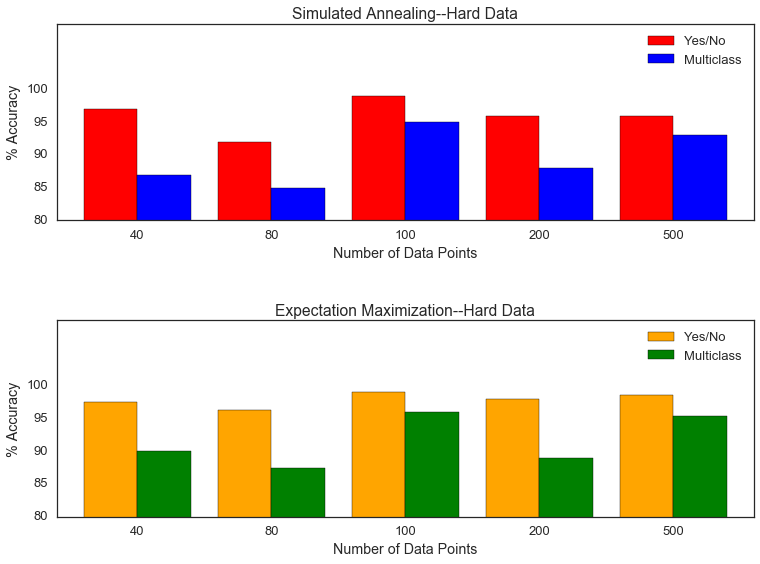

In [34]:
plt.subplot(2,1,1)
plt.tight_layout(0.5,5,0.5)
plt.bar(range(5),SimAn_YN_hard,0.4, color='red', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, SimAn_MC_hard, 0.4, color="blue", label="Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Simulated Annealing--Hard Data")

plt.subplot(2,1,2)
plt.bar(range(5), results_YN_extrahard, 0.4, color='orange', label="Yes/No")
plt.bar(np.arange(0,5,1)+0.4, results_MC_multiple_extrahard, 0.4, color='green', label= "Multiclass")
plt.xlim(-0.2,5)
plt.ylim(80,110)
plt.ylabel("% Accuracy")
plt.yticks(np.arange(80,101,5))
plt.xticks(np.arange(0,5,1)+0.4, [40,80,100,200,500])
plt.xlabel("Number of Data Points")
plt.legend(loc='best')
plt.title("Expectation Maximization--Hard Data");